In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from skimage.io import imshow 
import keras
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.utils import np_utils
from keras.models import Sequential 
from keras.layers import Input, concatenate, Activation, UpSampling2D, Conv2D, MaxPooling2D, Flatten, Dropout, ZeroPadding2D 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import Model
from keras.models import load_model
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from keras.losses import binary_crossentropy
import keras.backend as K
import json
import os
from matplotlib.path import Path
from skimage.color import label2rgb
from matplotlib.pyplot import imread
from pycocotools.coco import COCO
from pycocotools import mask as cocomask
import skimage.io as io
import pylab
import random

# Importing

In [2]:
X = pd.read_csv('data/X_test_sat4.csv', header = None)
y = pd.read_csv('data/y_test_sat4.csv', header = None)

In [3]:
X.values

array([[130, 120, 113, ..., 131, 131, 172],
       [164, 139, 111, ..., 152, 127, 202],
       [120, 114, 114, ..., 183, 186, 206],
       ...,
       [145, 141, 125, ..., 145, 131, 163],
       [151, 134, 126, ..., 105,  96, 138],
       [158, 155, 145, ..., 136, 126, 165]], dtype=int64)

In [4]:
y.values

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       ...,
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]], dtype=int64)

# Shape

In [5]:
X.shape

(100000, 3136)

# Visualizing RGB band

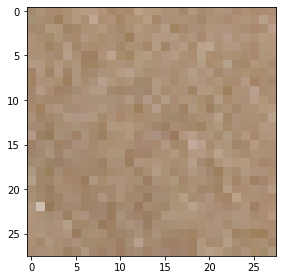

In [40]:
imshow(np.squeeze(((X.values.reshape([-1,28,28,4]))/255.0)[1,:,:,0:3]).astype(float)) 
plt.show()

In [6]:
def label(y):
    label_names = []
    barren = [1,0,0,0]
    trees = [0,1,0,0]
    grass = [0,0,1,0]
    other = [0,0,0,1]
    for row in y.values:
        if np.array_equal(row, barren):
            label_names.append('Barren_land')
        elif np.array_equal(row, trees):
            label_names.append('Trees')
        elif np.array_equal(row, grass):
            label_names.append('Grassland')
        elif np.array_equal(row, other):
            label_names.append('Other')
    return label_names

# Train test split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 43, test_size = 0.2)

label_names_train = label(y_train)
label_names_test = label(y_test)

# KNN

In [8]:
knn = KNeighborsClassifier(n_neighbors=10).fit(X_train, label_names_train)
y_pred_train = knn.predict(X_train)

# Accuracy on train set

In [9]:
accuracy_score(label_names_train, y_pred_train)

0.520325

# Test set

In [10]:
y_pred_test = knn.predict(X_test)
print(confusion_matrix(label_names_test, y_pred_test))

[[5098  235   15    0]
 [ 465 3084   32    3]
 [1460 3915 1630    1]
 [  19 3273  297  473]]


In [11]:
print(classification_report(label_names_test, y_pred_test))

              precision    recall  f1-score   support

 Barren_land       0.72      0.95      0.82      5348
   Grassland       0.29      0.86      0.44      3584
       Other       0.83      0.23      0.36      7006
       Trees       0.99      0.12      0.21      4062

    accuracy                           0.51     20000
   macro avg       0.71      0.54      0.46     20000
weighted avg       0.74      0.51      0.47     20000



In [12]:
accuracy_score(label_names_test, y_pred_test)

0.51425

# Normalizing and reshaping

In [13]:
X_norm = X.values.reshape([-1,28,28,4])
X_norm = X_norm/255.0

X_norm.shape

(100000, 28, 28, 4)

# Train test split

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X_norm, y, random_state = 43, test_size = 0.2)

# CNN

In [15]:
model = Sequential()
model.add(Conv2D(32, kernel_size = 3, activation = 'relu', input_shape = (28, 28, 4)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 3, activation = 'relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = 5, strides = 2, padding = 'same', activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size = 4, activation = 'relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(4, activation = 'softmax'))

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=['accuracy'])

In [16]:
history = model.fit(X_train, Y_train, 
                    batch_size = 64, epochs = 50,  
                    verbose=1, validation_data = (X_test, Y_test))

Epoch 1/50
1250/1250 [==============================] - 155s 122ms/step - loss: 0.1964 - accuracy: 0.9349 - val_loss: 1.1227 - val_accuracy: 0.7335

Epoch 00001: val_accuracy improved from -inf to 0.73350, saving model to model.h5
Epoch 2/50
1250/1250 [==============================] - 150s 120ms/step - loss: 0.1079 - accuracy: 0.9659 - val_loss: 0.8912 - val_accuracy: 0.8390

Epoch 00002: val_accuracy improved from 0.73350 to 0.83905, saving model to model.h5
Epoch 3/50
1250/1250 [==============================] - 150s 120ms/step - loss: 0.0879 - accuracy: 0.9722 - val_loss: 0.1897 - val_accuracy: 0.9341

Epoch 00003: val_accuracy improved from 0.83905 to 0.93405, saving model to model.h5
Epoch 4/50
1250/1250 [==============================] - 151s 120ms/step - loss: 0.0751 - accuracy: 0.9763 - val_loss: 2.4799 - val_accuracy: 0.5477

Epoch 00004: val_accuracy did not improve from 0.93405
Epoch 5/50
1250/1250 [==============================] - 150s 120ms/step - loss: 0.0658 - accuracy

# Plot of accuracy

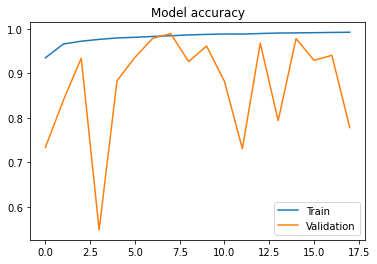

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')

plt.legend(['Train', 'Validation'])
plt.show()

# Plot of loss

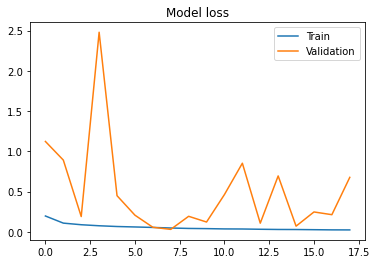

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')

plt.legend(['Train', 'Validation'])
plt.show()

# Evaluating the model

In [19]:
load_model = load_model('model.h5')

i, accuracy_train = load_model.evaluate(X_train, Y_train)
accuracy_train

2500/2500 [==============================] - 36s 14ms/step - loss: 0.0276 - accuracy: 0.9909


0.9909124970436096

In [20]:
j, accuracy_test = load_model.evaluate(X_test, Y_test)
accuracy_test

625/625 [==============================] - 9s 14ms/step - loss: 0.0302 - accuracy: 0.9893


0.9892500042915344

# Predicting

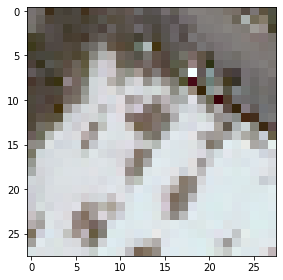

Prediction:

100.0% Barren land

0.0% Trees

0.0% Grasslands

0.0% Other



In [23]:
predicted = load_model.predict(X_norm[-1000:])

index = 2
imshow(np.squeeze(X_norm[index,:,:,0:3]).astype(float))
plt.show()

print('Prediction:\n')
print('{:.1f}% Barren land\n'.format(predicted[index,0]*100))
print('{:.1f}% Trees\n'.format(predicted[index,1]*100))
print('{:.1f}% Grasslands\n'.format(predicted[index,2]*100))
print('{:.1f}% Other\n'.format(predicted[index,3]*100))

# Segmenting Buildings

In [2]:
data_directory = "data/"
annotation_file_template = "{}/{}/annotation{}.json"

TRAIN_IMAGES_DIRECTORY = "data/images"
TRAIN_ANNOTATIONS_PATH = "data/annotation.json"
TRAIN_ANNOTATIONS_SMALL_PATH = "data/annotation-small.json"

In [3]:
with open('data/annotation.json', 'r') as file:
    annot_data = json.load(file)

train = COCO(TRAIN_ANNOTATIONS_PATH)

loading annotations into memory...
Done (t=22.72s)
creating index...
index created!


In [4]:
train_ids = train.getImgIds(catIds=train.getCatIds())
train_obj = [train.loadImgs(x) for x in train_ids]
train_path = [os.path.join(TRAIN_IMAGES_DIRECTORY, x[0]["file_name"]) for x in train_obj]

In [5]:
trix = []

for i in range(500):
    path = train_path[i]
    img = io.imread(path)
    img = np.pad(img, ((106,106), (106,106), (0,0)), mode='constant')
    trix.append(img)

In [6]:
annot_data_img = pd.DataFrame(annot_data['images'])
annot_data_img.sample(3)

,id,file_name,width,height
15924,154434,000000154434.jpg,300,300
106951,118752,000000118752.jpg,300,300
44825,115905,000000115905.jpg,300,300


In [7]:
annot_data_annot = pd.DataFrame(annot_data['annotations'])
annot_data_annot.sample(3)

,id,image_id,segmentation,area,bbox,category_id,iscrowd
335567,2182528,255855,"[[168, 245, 168, 256, 173, 256, 174, 299, 143,...",1732.0,"[143, 138, 156, 36]",100,0
583650,1996069,234151,"[[278.0, 231.99999999999997, 283.0, 142.999999...",1739.0,"[142.99999999999997, 278.0, 157.00000000000003...",100,0
2117435,979286,114992,"[[242, 224, 242, 254, 227, 253, 158, 253, 158,...",3866.0,"[158, 158, 96, 84]",100,0


# Merging both parts of the json file

In [8]:
img_set = pd.merge(annot_data_annot, annot_data_img, how='left', left_on = 'image_id', right_on='id').dropna()
img_set.sample(2)

,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
1568813,2355440,276080,"[[41.0, 99.0, 52.0, 99.0, 52.0, 90.0, 110.0, 8...",5308.0,"[41.0, 41.0, 142.0, 70.0]",100,0,276080,000000276080.jpg,300,300
2220055,1166967,136982,"[[128.0, 91.0, 128.0, 81.0, 136.0, 81.0, 136.0...",80.0,"[81.0, 128.0, 55.0, 8.0]",100,0,136982,000000136982.jpg,300,300


# Visualizing images

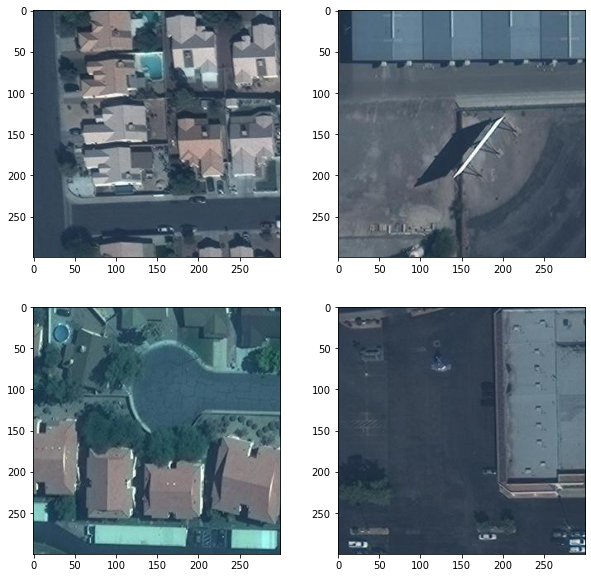

In [9]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))

for c_ax, (_, c_row) in zip(m_axs.flatten(), annot_data_img.sample(4).iterrows()):
    img_data = imread(os.path.join('data/images', c_row['file_name']))
    c_ax.imshow(img_data)

# Creating boxes with annotations data

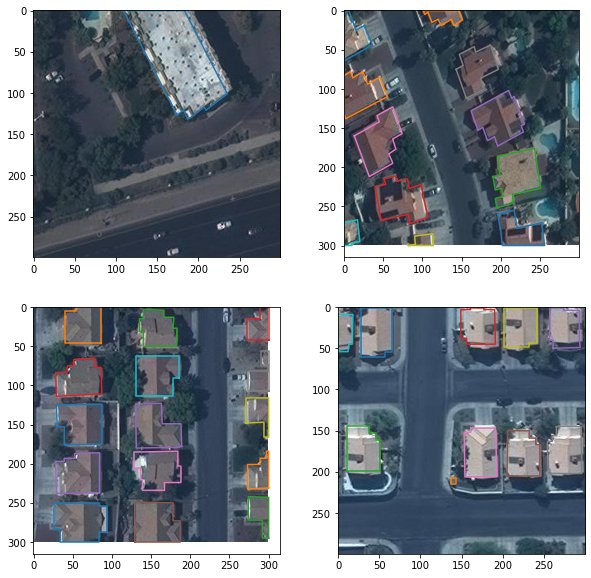

In [10]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), img_set.groupby('image_id')):
    img_data = imread(os.path.join('data/images', c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [11]:
def generate_label(x):
    img = np.zeros((300,300))
    
    for ann in x:
        rle = cocomask.frPyObjects(ann['segmentation'], 300, 300)
        m = cocomask.decode(rle)
        m = m.reshape((300, 300))
        img = img + m
    
    return img

In [12]:
triy = []
for i in range(500):
    train_annotation_id = train.getAnnIds(imgIds=train_ids[i])
    train_annotation = train.loadAnns(train_annotation_id)
    y_train = generate_label(train_annotation)
    y_train = y_train.reshape(300, 300, 1)
    y_train = np.pad(y_train, ((106,106), (106,106), (0,0)), mode='constant')
    triy.append(y_train)

In [13]:
x_train = np.asarray(trix)
y_train = np.asarray(triy)

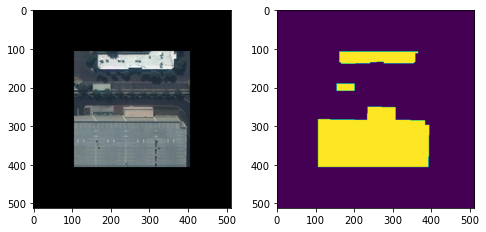

In [14]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(2, 2, 1)
plt.imshow(x_train[5].astype('uint8'))

fig.add_subplot(2, 2, 2)
plt.imshow(y_train[5].squeeze())

In [15]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [17]:
input_shape=(512, 512, 3)
num_classes=1

inputs = Input(shape=input_shape)

down0a = Conv2D(16, (3, 3), padding='same')(inputs)
down0a = BatchNormalization()(down0a)
down0a = Activation('relu')(down0a)
down0a = Conv2D(16, (3, 3), padding='same')(down0a)
down0a = BatchNormalization()(down0a)
down0a = Activation('relu')(down0a)
down0a_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0a)

down0 = Conv2D(32, (3, 3), padding='same')(down0a_pool)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0 = Conv2D(32, (3, 3), padding='same')(down0)
down0 = BatchNormalization()(down0)
down0 = Activation('relu')(down0)
down0_pool = MaxPooling2D((2, 2), strides=(2, 2))(down0)

center = Conv2D(1024, (3, 3), padding='same')(down0_pool)
center = BatchNormalization()(center)
center = Activation('relu')(center)
center = Conv2D(1024, (3, 3), padding='same')(center)
center = BatchNormalization()(center)
center = Activation('relu')(center)

up0 = UpSampling2D((2, 2))(center)
up0 = concatenate([down0, up0], axis=3)
up0 = Conv2D(32, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)
up0 = Conv2D(32, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)
up0 = Conv2D(32, (3, 3), padding='same')(up0)
up0 = BatchNormalization()(up0)
up0 = Activation('relu')(up0)

up0a = UpSampling2D((2, 2))(up0)
up0a = concatenate([down0a, up0a], axis=3)
up0a = Conv2D(16, (3, 3), padding='same')(up0a)
up0a = BatchNormalization()(up0a)
up0a = Activation('relu')(up0a)
up0a = Conv2D(16, (3, 3), padding='same')(up0a)
up0a = BatchNormalization()(up0a)
up0a = Activation('relu')(up0a)
up0a = Conv2D(16, (3, 3), padding='same')(up0a)
up0a = BatchNormalization()(up0a)
up0a = Activation('relu')(up0a)

classify = Conv2D(num_classes, (1, 1), activation='sigmoid')(up0a)
model = Model(inputs=inputs, outputs=classify)
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coeff, 'accuracy'])

In [19]:
history = model.fit(x=x_train, y=y_train, batch_size=2, epochs=1, verbose=1)

pred = model.predict(x_train[0:])

250/250 [==============================] - 53330s 213s/step - loss: 0.7960 - dice_coeff: 0.4202 - accuracy: 0.9179


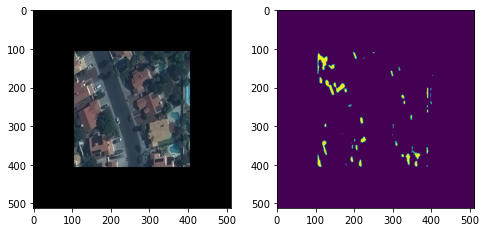

In [21]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(2, 2, 1)
plt.imshow(x_train[0].astype('uint8'))

fig.add_subplot(2, 2, 2)
plt.imshow(pred[0].astype('uint8'))

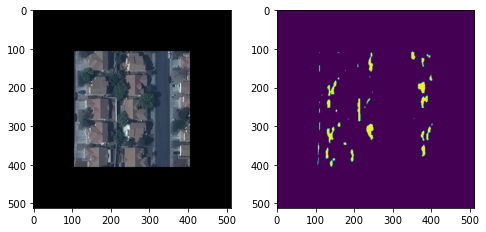

In [22]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(2, 2, 1)
plt.imshow(x_train[1].astype('uint8'))

fig.add_subplot(2, 2, 2)
plt.imshow(pred[1].astype('uint8'))

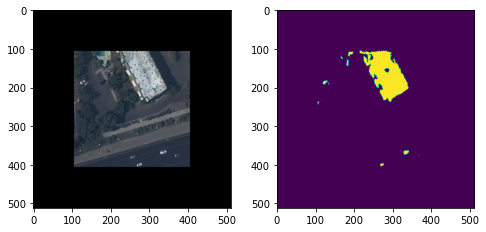

In [23]:
fig = plt.figure(figsize=(8, 8))
fig.add_subplot(2, 2, 1)
plt.imshow(x_train[2].astype('uint8'))

fig.add_subplot(2, 2, 2)
plt.imshow(pred[2].astype('uint8'))